In [34]:
# Written by Zack Gainsforth, 2018

%pylab nbagg
import hyperspy.api as hs
import glob2 as glob
from serReader import serReader
from tifffile import imsave, imread
import os
import re
from scipy.ndimage.interpolation import shift

Populating the interactive namespace from numpy and matplotlib


/Users/Zack/anaconda/envs/conda36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'imread', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Instructions on calling GenFire from python here: http://genfire-em.com/about/

# Step 1: Find all the Bruker files. 
They should be named num.bcf where num is the stage tilt, e.g. 0, 10, 15, -5, -15, etc.

In [35]:
Bcfs = glob.glob('*.bcf')
# print(Bcfs)
NewBcfs = []
for i in Bcfs:
    if i[0] == 'n':
        NewName = '-'+i[1:]
        NewBcfs.append(NewName)
        os.system('mv %s %s'%(i, NewName))
    else:
        NewBcfs.append(i)
Bcfs = NewBcfs
Nums = list(map(lambda s: float(s[:-4]), Bcfs))
Nums.sort()

# Step 2: Read all the files into memory.
Loop through all the BCF files and extract EDS maps for each element we want.  We will have a stack for each element, and each stack is a tilt sequence.

In [36]:
# What size should the rebin be to.
# Usually we acquire EDS maps at too high a resolution and we want to downsample to get a better result.
rebinsize = 64

# And write them to a tif.
SignalList = ['HAADF', 'Al', 'C', 'Ca', 'Cr', 'Fe', 'Ga', 'Mg', 'Na', 'Ni', 'O', 'P', 'Pt', 'S', 'Si']
for s in SignalList:
    exec(s + ' = []')

def WriteFile(n):
    fname = n+'.bcf'
    print(fname)
    x = hs.load(fname)
    HAADF.append(x[0].data) # The HAADF doesn't get rebinned.
    El = x[1].get_lines_intensity(['Al_Ka', 'C_Ka', 'Ca_Ka', 'Cr_Ka', 'Fe_Ka', 'Ga_Ka', 'Mg_Ka', 'Na_Ka', 'Ni_Ka', 'O_Ka', 'P_Ka', 'Pt_La', 'S_Ka', 'Si_Ka'])
    for i, s in enumerate(SignalList):
        if s == 'HAADF':
            continue
        exec(s + '.append(El[%d-1].rebin((rebinsize,rebinsize)).data.copy().astype("int32"))'%i)
    
for n in Nums:
    if n < 0:
        # Filenames starting with a minus need an extra character.
        WriteFile('%d'%(n))
    else:
        WriteFile('%d'%(n))

-55.bcf
-50.bcf
-45.bcf
-40.bcf
-35.bcf
-30.bcf
-25.bcf
-20.bcf
-15.bcf
-10.bcf
-5.bcf
0.bcf
5.bcf
10.bcf
15.bcf
20.bcf
25.bcf
30.bcf
35.bcf
40.bcf
45.bcf
50.bcf
55.bcf
60.bcf
65.bcf
70.bcf


In [40]:
# Write out all the stacks as tiff files.
for i, s in enumerate(SignalList):
    npStack = np.array(eval(s))
    if not os.path.exists('Element Stacks'):
        os.mkdir('Element Stacks')
    imsave(os.path.join('Element Stacks',s+'.tif'), npStack)
    
# Make a tilts file
with open(os.path.join('Element Stacks','tilts.txt'), 'w') as f:
    for n in Nums:
        f.write(f'0.0 {n:0.1f} 0.0\n')

# HALT!!!! 
At this point we have to align the stacks.  Since they all are aligned the same, we first align the HAADF and then apply the same alignment to all the EDS stacks.  In order for that to work, we need to align the HAADF in such a way as we have an output file of all the offsets.

<b>Method 1:</b> do a MultiStackReg on HAADF.tif in ImageJ and save it as HAADFAligned.tif and the transformations as TransformationMatrices.txt.  This will only work if all the images are aligned to the first one.


In [38]:
# Read in the translations file written by ImageJ.
with open(os.path.join('Element Stacks', 'TransformationMatrices.txt'), 'r') as f:
    s = f.read()
    
translations = re.findall(pattern='([\d\.]*)\t([\d\.]*)', string=s)

# There are 6 lines in each translation from the output file.  
# The zeroth is the new position, the third is the original position.
# The other lines are for rotations which we are not using.
# Example:
# [('236.81374221505683', '288.85170101351565'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ('256.0', '256.0'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ('246.23227371186195', '229.14170151652533'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ('256.0', '256.0'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ('264.2877416986045', '281.32142526192746'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ('256.0', '256.0'),
#  ('0.0', '0.0'),
#  ('0.0', '0.0'),
#  ...
 

# There should be as many translations as there are images-1 because we are registering to the first image.
assert(len(translations)/6 == len(Nums)-1)

offsets = []
offsets.append(np.array((0,0))) # MultiStackReg will ignore the first image since others are registered relative to it.
# Loop through all the translation info, image by image (6 lines at a time).
for i in range(0, len(translations), 6):
    NewPos = translations[i] # Image shifted to here
    OrigPos = translations[i+3] # Image started here
    # How much to shift:
    offset = -np.array((float(NewPos[1]) - float(OrigPos[1]), float(NewPos[0]) - float(OrigPos[0])))
    if len(offsets) > 0:
        offset += offsets[-1]
    offsets.append(offset)

<b>Method 2:</b> Align the images using a manual alignment in Tomviz.  For this to work, it has to be the only data source, and the tomviz file needs to be saved as HAADF_Alignment.tvsm.  There need to be the following exact sequence:
1. Assign tilt angles.
2. Manual translation align.
3. Manual Shift/rotate.  Only adjust the y-axis of the shift. (If you need to adjust the rotation then write some code! :-).

Like this:

<img  src="Screen Shot 2018-04-20 at 4.48.11 PM.png"/>

In [31]:
# Read in the tvsm file (which is XML) into a python dictionary structure.  So cool!
import xmltodict
with open(os.path.join('Element Stacks', 'HAADF_alignment.tvsm')) as f:
    tvsm = xmltodict.parse(f.read())
    
# We just go to the first DataSource, second operator and check that it is TranslateAlign.
OperatorType = tvsm['tomvizState']['DataSource']['Operator'][1]['@operator_type']
if OperatorType != 'TranslateAlign':
    print("Error!  Expecting second operator to be TranslateAlign.  Check the XML in HAADF_alignment.tvsm.")
    
# Find out how many frames.
NumOffsets = int(tvsm['tomvizState']['DataSource']['Operator'][1]['@number_of_offsets'])
print(f'Number of frames is: {NumOffsets}')

# For each frame get the offset.
Offsets = tvsm['tomvizState']['DataSource']['Operator'][1]['offset']
if len(Offsets) != NumOffsets:
    print('NumOffsets != the number of frames.  Brwooop!  Brwooop!')

# And get the shift to move the axis to the center.
# This will be added to the offset.
AxisShift = int(tvsm['tomvizState']['DataSource']['Operator'][2]['arguments']['variant']['variant'][1]['@value'])
print(f'Axis shift is: {AxisShift}')

offsets = []
for OneOffset in Offsets:
    x = int(OneOffset['@y_offset']) + AxisShift
    y = int(OneOffset['@x_offset'])
    offsets.append(np.array((x,y)))

FileNotFoundError: [Errno 2] No such file or directory: 'Element Stacks/HAADF_alignment.tvsm'

# Alignment done, continue
Now you can just apply the alignment.

In [41]:
# Apply the shifts to all the images.

doall = open(os.path.join('Element Stacks','runall.sh'), 'w')

binning = 2
for s in SignalList:
    print('Aligning', s)
    Sig = eval(s)
    SigAlign = []
    #SigAlign.append(Sig[0])

    # Apply the shifts to every image in this signal stack.
    for i in range(len(offsets)):
        print(offsets[i])
        if s == 'HAADF':
            SigAlign.append(shift(Sig[i], offsets[i]))
        else:
            SigAlign.append(shift(Sig[i], offsets[i]/binning))
    
    # Save the result as a tif for easy viewing.
    imsave(os.path.join('Element Stacks',s+'_aligned.tif'), np.array(SigAlign))
    
    # Swap the numpy axes to be how GENFire expects it and save npy files.
    SigAlign = np.array(SigAlign)
    SigAlign = np.swapaxes(np.swapaxes(SigAlign, 0,1), 1,2)
    np.save(os.path.join('Element Stacks',s+'_aligned.npy'), np.array(SigAlign))
    
    slurmscript = '#!/bin/bash -l\n'\
        '# Job name:\n'\
        '#SBATCH --job-name=GENFIRE_%s\n'\
        '#\n'\
        '# Partition:\n'\
        '#SBATCH --partition=partitionname\n'\
        '#\n'\
        '# Account:\n'\
        '#SBATCH --account=accountname\n'\
        '#\n'\
        '# Wall clock limit:\n'\
        '#SBATCH --time=2:00:00\n'\
        '#\n'\
        '# Processors\n'\
        '#SBATCH --ntasks=8\n'\
        '#\n'\
        '# Mail type:\n'\
        '#SBATCH --mail-type=all\n'\
        '#\n'\
        '# Mail user:\n'\
        '#SBATCH --mail-user=myemailhere@lbl.gov\n'\
        '#\n'\
        '## Run command\n'\
        '\n'\
        'cd $SLURM_SUBMIT_DIR;\n'\
        'module load python\n'\
        'source activate conda36\n'\
        'python DoGenfire.py %s\n' % (s, s)
    with open(os.path.join('Element Stacks',s+'_slurm.sh'), 'w') as f:
        f.write(slurmscript)
    
    doall.write('sbatch %s_slurm.sh\n'%s)
    doall.write('sleep 3\n')

doall.close()

Aligning HAADF
[0 0]
[-0.33284436  3.13300094]
[ 11.15186616 -16.94282086]
[ 0.04400947  2.43282909]
[ 2.40227636 -5.4128743 ]
[  2.99322335 -10.37026015]
[-9.09311786 -8.17792754]
[ -5.91665118 -11.82615917]
[-16.8905327   -5.72390591]
[-12.25307581 -10.12816062]
[-16.96340367  -6.96715322]
[-18.4401276   -7.83396992]
[-12.21616366  -9.91262547]
[-12.54888294  -7.23105928]
[-15.20336705 -11.75182535]
[-17.02120608  -4.38014771]
[-11.91152099 -11.95611971]
[-9.23071497 -9.21547372]
[-6.63721284 -8.65987993]
[-8.77758139 -9.81014889]
[ -9.11800935 -18.12475553]
[ -5.24252026 -10.81892509]
[  2.85124672 -11.50409351]
[-2.80020673 -8.21757704]
[-10.66678457  -5.78574294]
[  1.07065725 -15.47081913]
Aligning Al
[0 0]
[-0.33284436  3.13300094]
[ 11.15186616 -16.94282086]
[ 0.04400947  2.43282909]
[ 2.40227636 -5.4128743 ]
[  2.99322335 -10.37026015]
[-9.09311786 -8.17792754]
[ -5.91665118 -11.82615917]
[-16.8905327   -5.72390591]
[-12.25307581 -10.12816062]
[-16.96340367  -6.96715322]
[-18.

[-16.8905327   -5.72390591]
[-12.25307581 -10.12816062]
[-16.96340367  -6.96715322]
[-18.4401276   -7.83396992]
[-12.21616366  -9.91262547]
[-12.54888294  -7.23105928]
[-15.20336705 -11.75182535]
[-17.02120608  -4.38014771]
[-11.91152099 -11.95611971]
[-9.23071497 -9.21547372]
[-6.63721284 -8.65987993]
[-8.77758139 -9.81014889]
[ -9.11800935 -18.12475553]
[ -5.24252026 -10.81892509]
[  2.85124672 -11.50409351]
[-2.80020673 -8.21757704]
[-10.66678457  -5.78574294]
[  1.07065725 -15.47081913]
Aligning S
[0 0]
[-0.33284436  3.13300094]
[ 11.15186616 -16.94282086]
[ 0.04400947  2.43282909]
[ 2.40227636 -5.4128743 ]
[  2.99322335 -10.37026015]
[-9.09311786 -8.17792754]
[ -5.91665118 -11.82615917]
[-16.8905327   -5.72390591]
[-12.25307581 -10.12816062]
[-16.96340367  -6.96715322]
[-18.4401276   -7.83396992]
[-12.21616366  -9.91262547]
[-12.54888294  -7.23105928]
[-15.20336705 -11.75182535]
[-17.02120608  -4.38014771]
[-11.91152099 -11.95611971]
[-9.23071497 -9.21547372]
[-6.63721284 -8.65987

# At this point all the EDS stacks are aligned and you can fire up GENFires for them.

# Some other registration approaches I've played with in the past.

<IPython.core.display.Javascript object>


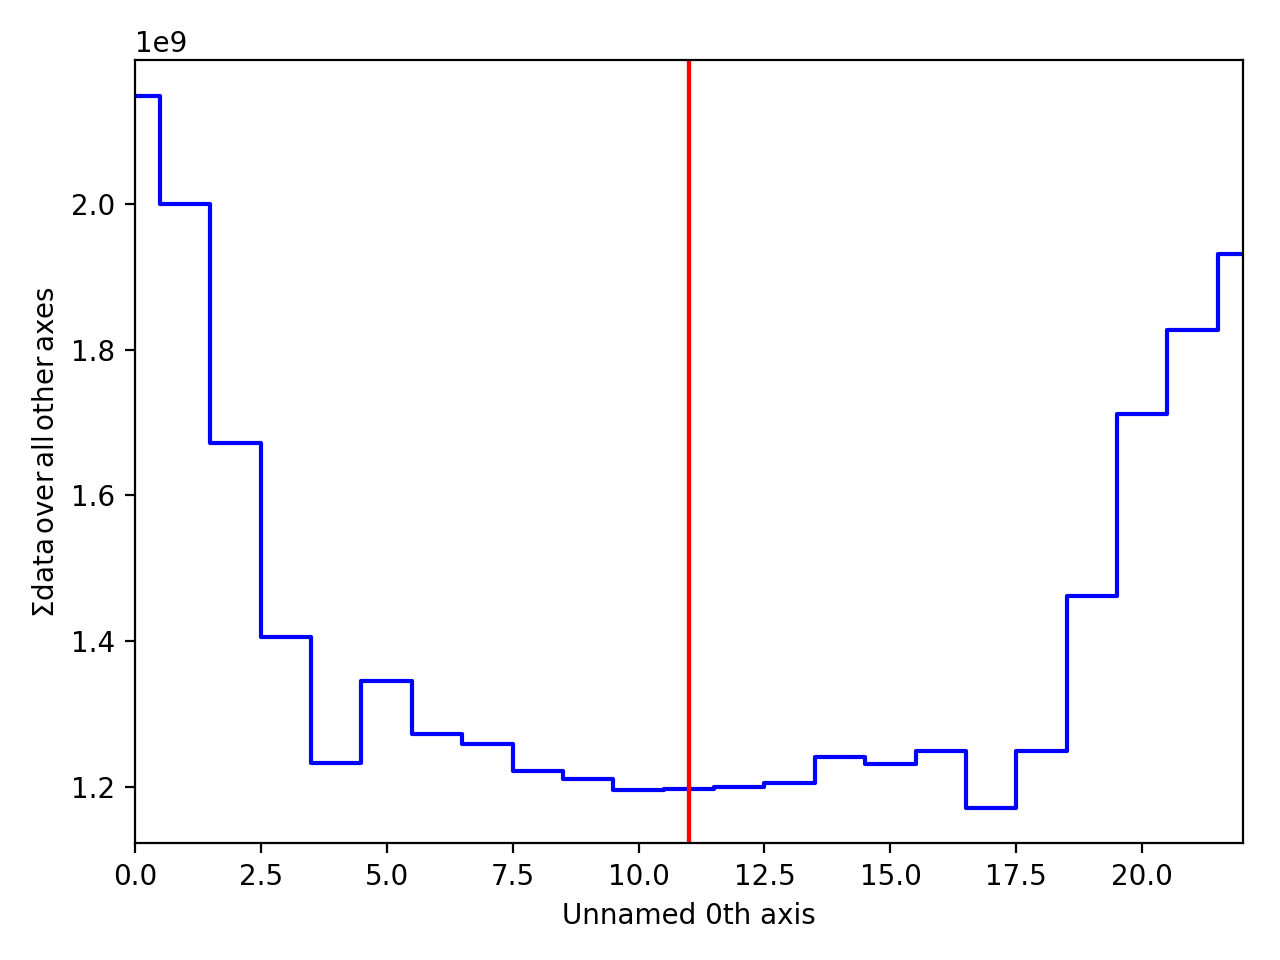

<IPython.core.display.Javascript object>


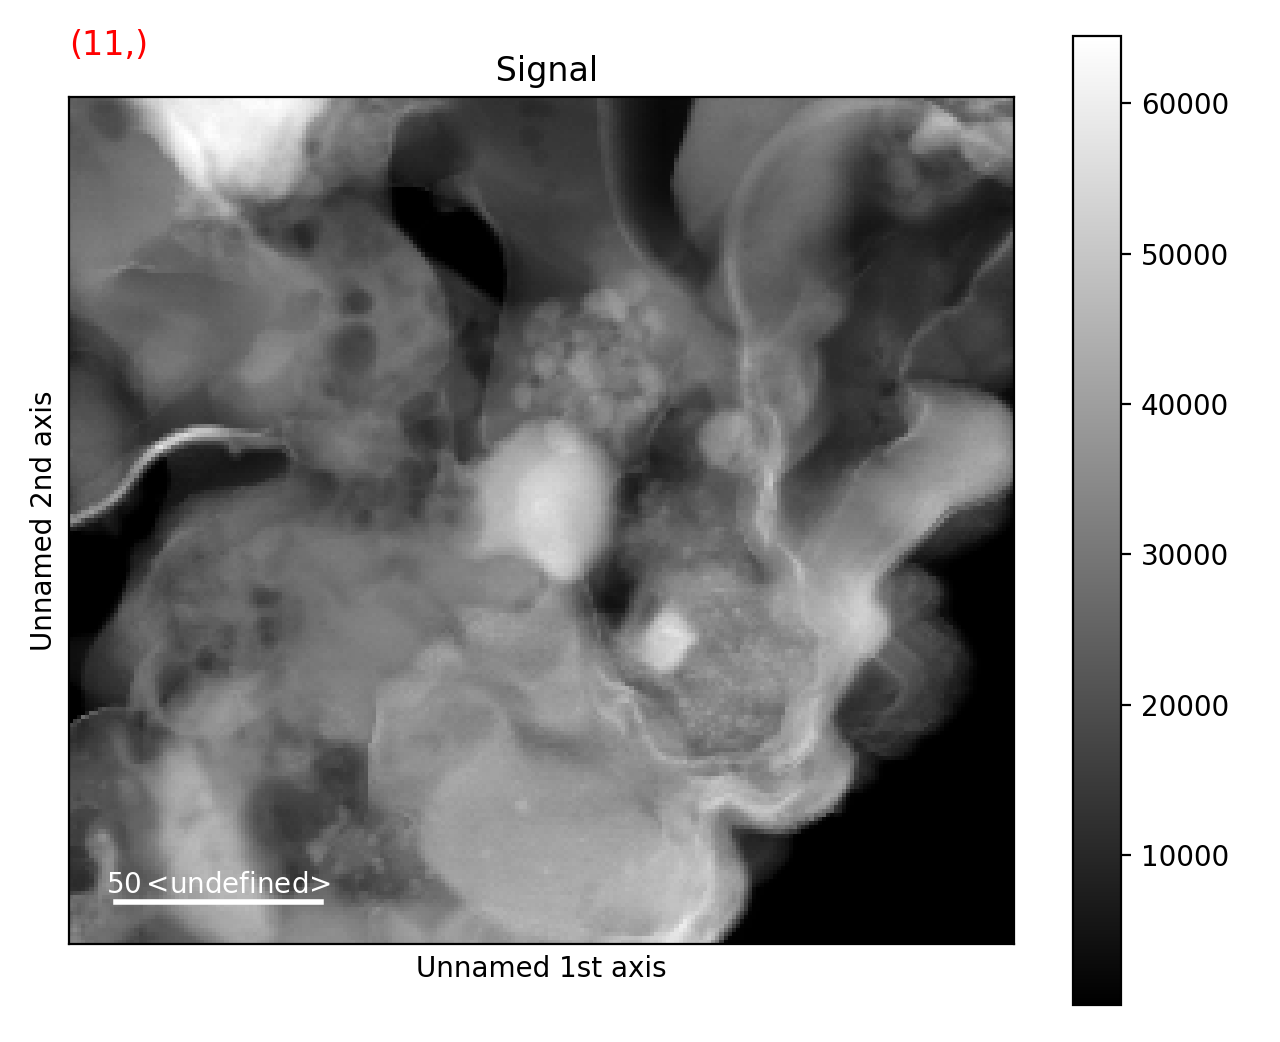

In [33]:
StackAlign = hs.signals.Signal2D(HAADF)
S2 = StackAlign.align2D()
StackAlign.plot()

In [64]:
import imreg_dft

print(imreg_dft.translation(HAADF[0], HAADF[1]))
HAADFReg = []
HAADFReg.append(HAADF[0])
for i in range(1, len(HAADF)):
    tvec = imreg_dft.translation(HAADF[i-1], HAADF[i])
    print(tvec['tvec'])
    HAADFReg.append(imreg_dft.transform_img(HAADF[i], tvec=tvec['tvec']))
    


{'tvec': array([-33.8393811 ,  19.03266518]), 'success': 0.096294723611813057, 'angle': 0}
[-33.8393811   19.03266518]
[ 28.01530697  10.7978632 ]
[-25.11391821  -7.86684622]
[ 23.0702638   -6.98664801]
[ -5.88981896  19.12638869]
[-31.81820052  -9.00642787]
[ 40.9368323  -13.50696723]
[-0.08009547  0.02131036]
[-15.97333975 -12.18822169]
[-28.25592078  26.07145559]
[ 4.9024495  -3.18818693]
[ 47.21118656 -32.06886613]
[-15.18781038  26.16505911]
[ 0.31897419  0.34951543]


In [74]:
from skimage.feature import register_translation
from skimage.transform import EuclideanTransform, warp

print(register_translation(HAADF[0], HAADF[1]))
HAADFReg = []
HAADFReg.append(HAADF[0])
for i in range(1, len(HAADF)):
    shift, error, diffphase = register_translation(HAADF[i-1], HAADF[i])
    print(shift)
    HAADFReg.append(warp(HAADF[i], EuclideanTransform(translation=shift)))
    



(array([-32.,  18.]), 0.29716657447141293, 6.9623500950971265e-16)
[-32.  18.]
[ 26.   8.]
[-25.  -7.]
[ 23.  -6.]
[ -6.  18.]
[-31.  -8.]
[ 39. -15.]
[-4.  5.]
[-15. -12.]
[-27.  26.]
[ 5. -3.]
[ 47. -32.]
[-16.  23.]
[ 4.  2.]


<IPython.core.display.Javascript object>


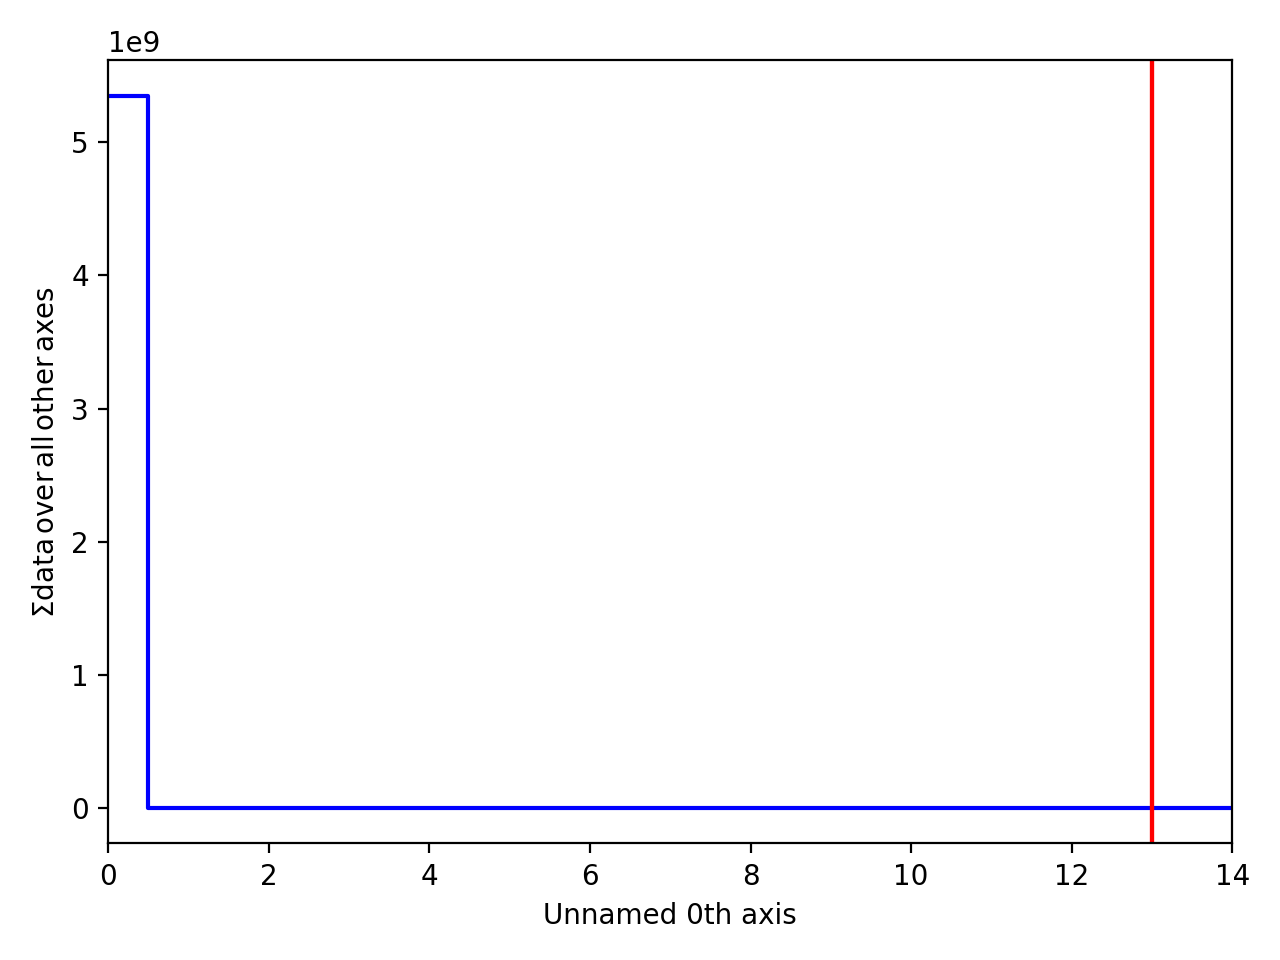

<IPython.core.display.Javascript object>


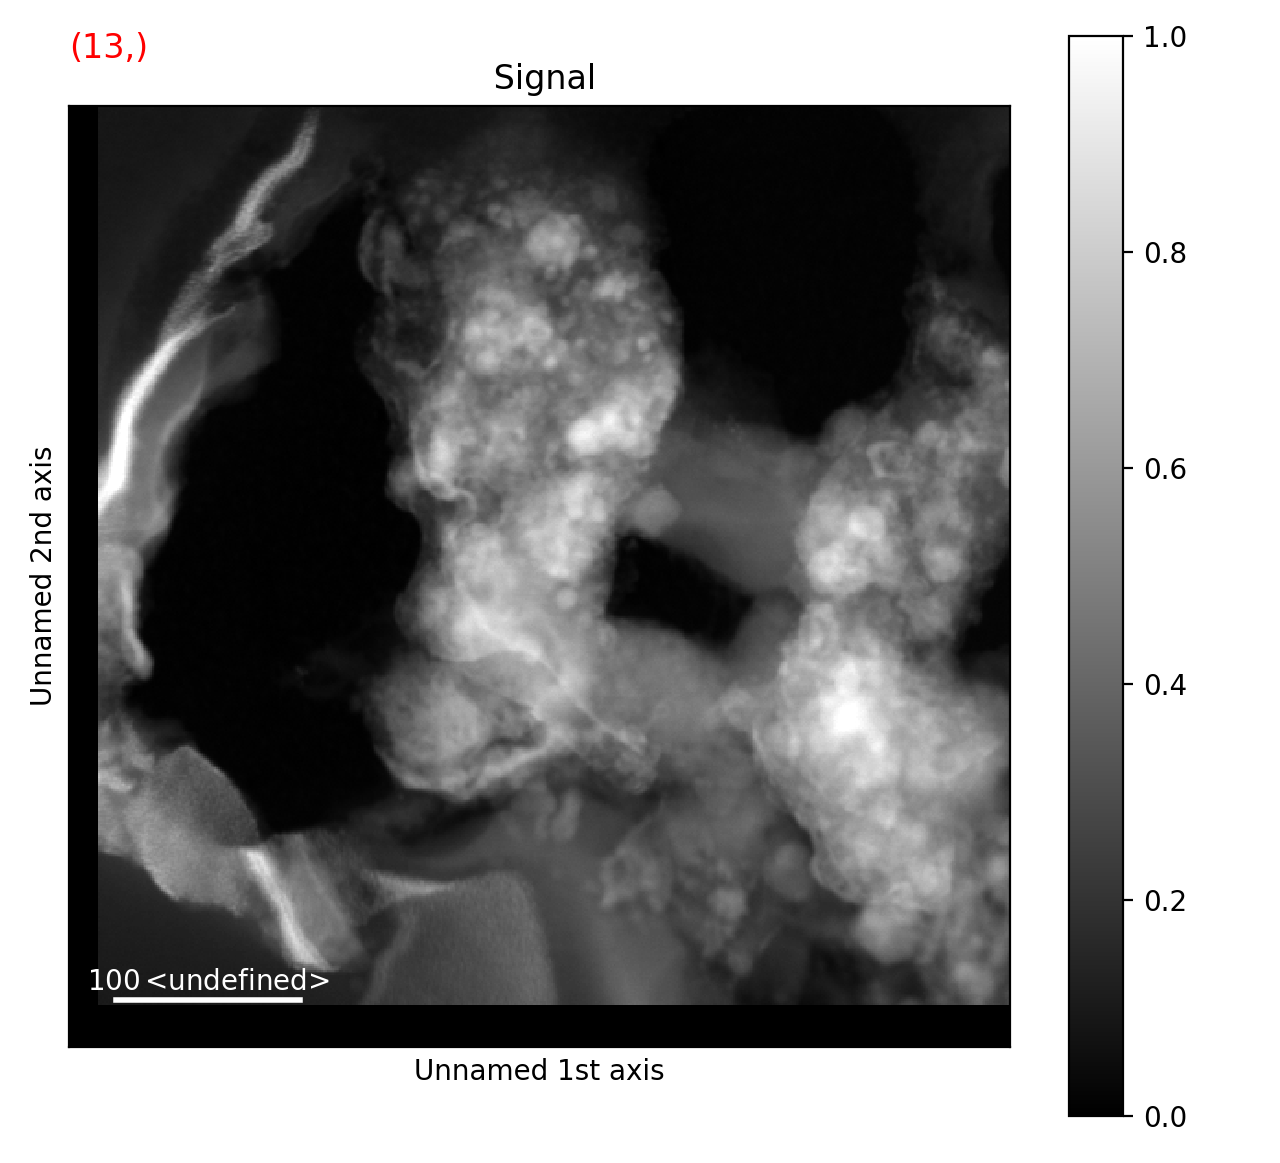

In [75]:
StackAlign = hs.signals.Signal2D(HAADFReg)
StackAlign.plot()

<IPython.core.display.Javascript object>


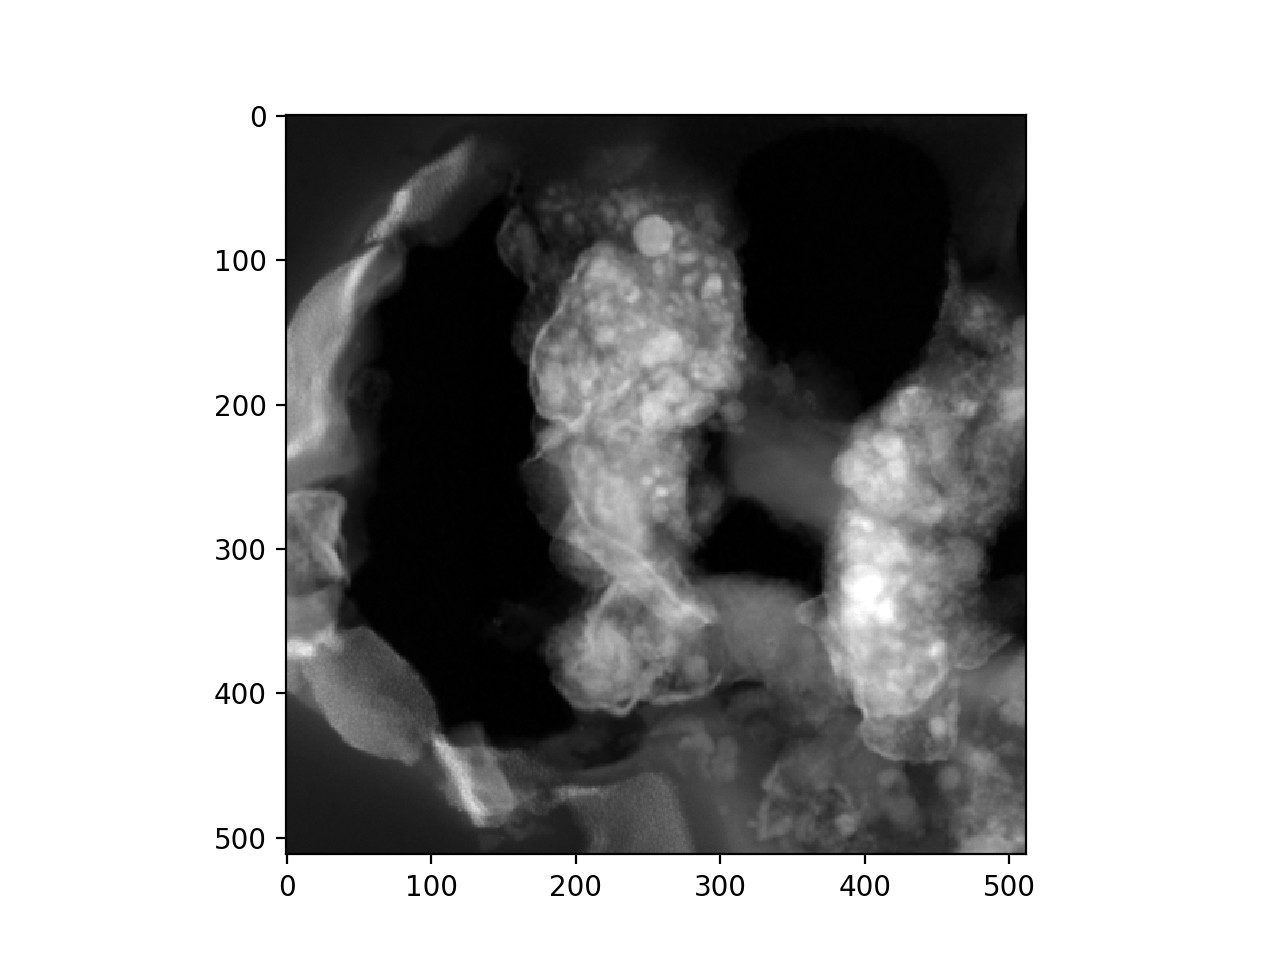

In [3]:
x=hs.load('-00.03.bcf')
y=x[0]
z=x[1]
imshow(y.data)

In [100]:
El = z.get_lines_intensity(['O_Ka', 'Si_Ka', 'S_Ka', 'Fe_Ka'])
O = El[0].rebin((128,128)).data.copy()
S = El[1].rebin((128,128)).data.copy()
Fe = El[2].rebin((128,128)).data.copy().astype('int32')

In [102]:
plt.imshow(Fe)
plt.show()

In [101]:
Fe.dtype

dtype('int32')

In [74]:
SignalList = ['HAADF', 'O', 'Mg', 'Si', 'S', 'Fe', 'Ni']
for s in SignalList:
    exec(s + ' = []')

